# Starbucks Capstone Challenge

# Project Overview

### Objective
The objective of this project is to predict which customer will complete an offer based on their attributes. This can help the company to identify customer segments that need/do not need to be made special offer.



### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

This data sets contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Problem Statement & Strategy

### Problem Statement
Which customer segment are likely to complete an offer?
The goal of this project is to combine transaction, demographic, and offer data to determine which demographic groups respond best to an offer.

### Strategy
In this project, I am interested to predict which customer will complete an offer or not. 
Since this is a classification problem, I will be using multiple classification algorithm as listed below:
* Logistic Regresssion
* Naive Bayes
* Stochastic Gradient Descent
* Support Vector Machine
* Random Forest
* K-Nearest Neighbors

The target variable will be an indicator whether a customer complete an offer or not.
In terms of predictors, I will consider customer attributes like age, income, gender etc.

# Metrics

To evaluate the classification models, I will consider the following metrics:
* Accuracy
* Precision
* Recall
* F1-Score

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import json
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Settings

In [2]:
# To view all generated results
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)

# Ignore pandas chained assignment errors
pd.options.mode.chained_assignment = None

# Widen the Jupyter Notebook as much as possible
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Portfolio Data

## Import Data

In [3]:
# read in the json files
portfolio = pd.read_json('data\\portfolio.json', orient='records', lines=True)

# Rename column 
portfolio.rename(columns={'id': 'offer_id', 'reward': 'offer_reward'}, inplace=True)

# Rearrange column order
portfolio = portfolio[['offer_id', 'offer_type', 'channels', 'duration', 'difficulty', 'offer_reward']]
portfolio = pd.DataFrame(portfolio)
portfolio

,offer_id,offer_type,channels,duration,difficulty,offer_reward
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,"[email, mobile, social]",7,10,10
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,"[web, email, mobile, social]",5,10,10
2,3f207df678b143eea3cee63160fa8bed,informational,"[web, email, mobile]",4,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,"[web, email, mobile]",7,5,5
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,"[web, email]",10,20,5
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,"[web, email, mobile, social]",7,7,3
6,fafdcd668e3743c1bb461111dcafc2a4,discount,"[web, email, mobile, social]",10,10,2
7,5a8bc65990b245e5a138643cd4eb9837,informational,"[email, mobile, social]",3,0,0
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,"[web, email, mobile, social]",5,5,5
9,2906b810c7d4411798c6938adc9daaa5,discount,"[web, email, mobile]",7,10,2


In [4]:
# View shape
portfolio.shape

(10, 6)

In [5]:
# Data general info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offer_id      10 non-null     object
 1   offer_type    10 non-null     object
 2   channels      10 non-null     object
 3   duration      10 non-null     int64 
 4   difficulty    10 non-null     int64 
 5   offer_reward  10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
# View missing values
portfolio.isnull().sum()

offer_id        0
offer_type      0
channels        0
duration        0
difficulty      0
offer_reward    0
dtype: int64

## Data Cleansing

In [7]:
# Check for duplicates
portfolio.columns.duplicated().sum()

0

### Offer Type

In [8]:
# View number of offer type
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

### Channels

In [9]:
# View channel
portfolio.channels.sample(10)
# Need to break this column into multiple columns of channel indicators

7         [email, mobile, social]
3            [web, email, mobile]
4                    [web, email]
1    [web, email, mobile, social]
6    [web, email, mobile, social]
5    [web, email, mobile, social]
2            [web, email, mobile]
8    [web, email, mobile, social]
9            [web, email, mobile]
0         [email, mobile, social]
Name: channels, dtype: object

In [10]:
# multiple columns of channel indicators
channels = ['web', 'email', 'mobile', 'social']

for channel in channels:
    portfolio['channel_' + channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
    
# Drop channel column
portfolio.drop(columns='channels', axis=1, inplace=True)
portfolio

,offer_id,offer_type,duration,difficulty,offer_reward,channel_web,channel_email,channel_mobile,channel_social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,7,10,10,0,1,1,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,5,10,10,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,4,0,0,1,1,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,7,5,5,1,1,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,10,20,5,1,1,0,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,7,3,1,1,1,1
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,10,2,1,1,1,1
7,5a8bc65990b245e5a138643cd4eb9837,informational,3,0,0,0,1,1,1
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,1,1,1,1
9,2906b810c7d4411798c6938adc9daaa5,discount,7,10,2,1,1,1,0


### Duration

In [11]:
# View duration (days)
portfolio.duration.value_counts().sort_index()

3     1
4     1
5     2
7     4
10    2
Name: duration, dtype: int64

### Difficulty

In [12]:
# View difficulty (min spend to complete the offer)
portfolio.difficulty.value_counts().sort_index()

0     2
5     2
7     1
10    4
20    1
Name: difficulty, dtype: int64

### Reward

In [13]:
# View reward
portfolio.offer_reward.value_counts().sort_index()

0     2
2     2
3     1
5     3
10    2
Name: offer_reward, dtype: int64

# Profile Data

## Import Data

In [14]:
# read in the json files
profile = pd.read_json('data/profile.json', orient='records', lines=True)
# Rename column 
profile.rename(columns={'id': 'cust_id', 'became_member_on': 'membership_dt'}, inplace=True)
# Rearrange column order
profile = profile[['cust_id', 'gender', 'age', 'income', 'membership_dt']]
profile

,cust_id,gender,age,income,membership_dt
0,68be06ca386d4c31939f3a4f0e3dd783,None,118,NaN,20170212
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.0,20170715
2,38fe809add3b4fcf9315a9694bb96ff5,None,118,NaN,20180712
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.0,20170509
4,a03223e636434f42ac4c3df47e8bac43,None,118,NaN,20170804
...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,54000.0,20180604
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61,72000.0,20180713
16997,01d26f638c274aa0b965d24cefe3183f,M,49,73000.0,20170126
16998,9dc1421481194dcd9400aec7c9ae6366,F,83,50000.0,20160307


In [15]:
profile.shape

(17000, 5)

In [16]:
# Data general info
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cust_id        17000 non-null  object 
 1   gender         14825 non-null  object 
 2   age            17000 non-null  int64  
 3   income         14825 non-null  float64
 4   membership_dt  17000 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [17]:
# View missing values
profile.isnull().sum()

cust_id             0
gender           2175
age                 0
income           2175
membership_dt       0
dtype: int64

In [18]:
# Check for duplicates
profile.columns.duplicated().sum()

0

## Data Cleansing

### Gender

In [19]:
# View gender
profile.gender.value_counts()
# Remove 'O' as there is only small number of them compared to M & F

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [20]:
# Remove 'O' as there is only small number of them compared to M & F
profile = profile[profile['gender'] != 'O']

### Age

In [21]:
# View age
profile.age.value_counts().sort_index()

18       70
19      135
20      131
21      137
22      130
23      126
24      138
25      135
26      155
27      139
28      134
29      128
30      129
31      111
32      136
33      150
34      145
35      116
36      174
37      196
38      170
39      176
40      197
41      186
42      223
43      211
44      191
45      230
46      210
47      226
48      284
49      311
50      283
51      357
52      344
53      364
54      356
55      342
56      336
57      348
58      401
59      354
60      325
61      306
62      315
63      335
64      308
65      279
66      280
67      309
68      255
69      240
70      249
71      228
72      190
73      203
74      190
75      157
76      152
77      137
78      135
79      116
80      115
81      116
82      103
83      102
84       81
85       69
86       54
87       66
88       64
89       51
90       51
91       47
92       39
93       29
94       33
95       22
96        8
97       13
98        5
99        5
100      11
101 

In [22]:
# Check customer aged 118
profile[profile['age'] == 118].count()
# These customers have missing values for gender and income
# Remove these customers as there is not much information to learn from

cust_id          2175
gender              0
age              2175
income              0
membership_dt    2175
dtype: int64

<AxesSubplot:>

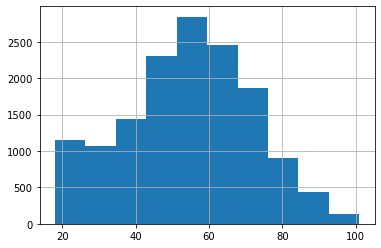

In [23]:
# Remove age == 118
profile = profile[profile['age'] != 118]
profile.age.hist(bins=10)

In [24]:
# Age group
def age_grp(x):
    if (x < 30):
        return ('a_below_30')
    elif (x >= 30) & (x < 40):
        return ('b_30_40')
    elif (x >= 40) & (x < 50):
        return ('c_40_50')
    elif (x >= 50) & (x < 60):
        return ('d_50_60')
    elif (x >= 60) & (x < 70):
        return ('e_60_70')
    elif (x >= 70):
        return ('f_70_&_above')
    else:
        return ('Error')
    
profile['age_grp'] = profile['age'].apply(age_grp)
profile['age_grp'].value_counts()

d_50_60         3485
e_60_70         2952
f_70_&_above    2846
c_40_50         2269
a_below_30      1558
b_30_40         1503
Name: age_grp, dtype: int64

### Income

In [25]:
# View income distribution
pd.options.display.float_format = "{:.2f}".format
profile.income.describe()

count    14613.00
mean     65435.71
std      21633.52
min      30000.00
25%      49000.00
50%      64000.00
75%      80000.00
max     120000.00
Name: income, dtype: float64

<AxesSubplot:>

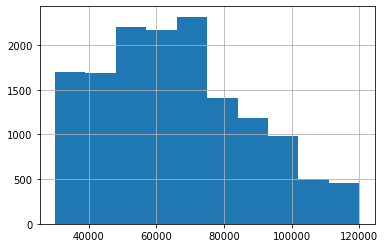

In [26]:
# View income distribution
profile.income.hist(bins=10)

In [27]:
# Income group
def income_grp(x):
     if (x < 50000):
        return ('a_below_50k')
     elif (x >= 50000) & (x < 75000):
        return ('b_50k_75k')
     elif (x >= 75000) & (x < 100000):
        return ('c_75k_100k')
     elif (x >= 100000):
        return ('d_100k_&_above')
     else:
        return ('Error')
    
profile['income_grp'] = profile['income'].apply(income_grp)
profile['income_grp'].value_counts()

b_50k_75k         6348
a_below_50k       3731
c_75k_100k        3443
d_100k_&_above    1091
Name: income_grp, dtype: int64

### Membership Date

In [28]:
# Date format
profile['membership_dt'] = pd.to_datetime(profile['membership_dt'], format='%Y%m%d')

# Membership year
profile['membership_year'] = profile['membership_dt'].dt.year

# Membership period
profile['membership_days'] = datetime.datetime.today().date() - profile['membership_dt'].dt.date

# removing the 'days' unit
profile['membership_days'] = profile['membership_days'].dt.days

profile

,cust_id,gender,age,income,membership_dt,age_grp,income_grp,membership_year,membership_days
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.00,2017-07-15,d_50_60,d_100k_&_above,2017,1706
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.00,2017-05-09,f_70_&_above,d_100k_&_above,2017,1773
5,e2127556f4f64592b11af22de27a7932,M,68,70000.00,2018-04-26,e_60_70,b_50k_75k,2018,1421
8,389bc3fa690240e798340f5a15918d5c,M,65,53000.00,2018-02-09,e_60_70,b_50k_75k,2018,1497
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.00,2017-11-11,d_50_60,b_50k_75k,2017,1587
...,...,...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,54000.00,2018-06-04,c_40_50,b_50k_75k,2018,1382
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61,72000.00,2018-07-13,e_60_70,b_50k_75k,2018,1343
16997,01d26f638c274aa0b965d24cefe3183f,M,49,73000.00,2017-01-26,c_40_50,b_50k_75k,2017,1876
16998,9dc1421481194dcd9400aec7c9ae6366,F,83,50000.00,2016-03-07,f_70_&_above,b_50k_75k,2016,2201


<AxesSubplot:>

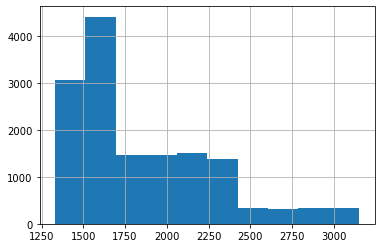

In [29]:
# View distribution
profile.membership_days.hist(bins=10)

In [30]:
# View distribution
profile.membership_days.describe()

count   14613.00
mean     1852.99
std       419.68
min      1330.00
25%      1538.00
50%      1688.00
75%      2128.00
max      3153.00
Name: membership_days, dtype: float64

In [31]:
# Membership duration
def membership_duration(x):
    if (x <= 1600):
        return ('a_4years_or_less')
    elif (x > 1600) & (x <= 2300):
        return ('b_4_6_years')
    elif (x > 2300):
        return ('c_More_than_6_years')
    else:
        return ('Error')
    
profile['membership_duration'] = profile['membership_days'].apply(membership_duration)
profile['membership_duration'].value_counts()

b_4_6_years            7204
a_4years_or_less       5160
c_More_than_6_years    2249
Name: membership_duration, dtype: int64

In [33]:
profile

,cust_id,gender,age,income,membership_dt,age_grp,income_grp,membership_year,membership_days,membership_duration
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.00,2017-07-15,d_50_60,d_100k_&_above,2017,1706,b_4_6_years
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.00,2017-05-09,f_70_&_above,d_100k_&_above,2017,1773,b_4_6_years
5,e2127556f4f64592b11af22de27a7932,M,68,70000.00,2018-04-26,e_60_70,b_50k_75k,2018,1421,a_4years_or_less
8,389bc3fa690240e798340f5a15918d5c,M,65,53000.00,2018-02-09,e_60_70,b_50k_75k,2018,1497,a_4years_or_less
12,2eeac8d8feae4a8cad5a6af0499a211d,M,58,51000.00,2017-11-11,d_50_60,b_50k_75k,2017,1587,a_4years_or_less
...,...,...,...,...,...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,F,45,54000.00,2018-06-04,c_40_50,b_50k_75k,2018,1382,a_4years_or_less
16996,2cb4f97358b841b9a9773a7aa05a9d77,M,61,72000.00,2018-07-13,e_60_70,b_50k_75k,2018,1343,a_4years_or_less
16997,01d26f638c274aa0b965d24cefe3183f,M,49,73000.00,2017-01-26,c_40_50,b_50k_75k,2017,1876,b_4_6_years
16998,9dc1421481194dcd9400aec7c9ae6366,F,83,50000.00,2016-03-07,f_70_&_above,b_50k_75k,2016,2201,b_4_6_years


# Transcript Data

## Import Data

In [32]:
# read in the json files
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
# Rename column 
transcript.rename(columns={'person': 'cust_id'}, inplace=True)
transcript

,cust_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [33]:
# View shape
transcript.shape

(306534, 4)

In [34]:
# Data general info
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   cust_id  306534 non-null  object
 1   event    306534 non-null  object
 2   value    306534 non-null  object
 3   time     306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [35]:
# View missing values
transcript.isnull().sum()

cust_id    0
event      0
value      0
time       0
dtype: int64

In [36]:
# Check for duplicates
transcript.columns.duplicated().sum()

0

## Data Cleansing

### Event

In [37]:
# View event
transcript.event.value_counts()
# Remove transaction event and offer received as I am only interested of participants with offer viewed and offer completed

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [38]:
# Remove transaction event and offer received as I am only interested of participants with offer viewed
transcript = transcript[transcript['event'].isin(['offer viewed', 'offer completed'])]
transcript.event.value_counts()

offer viewed       57725
offer completed    33579
Name: event, dtype: int64

### Value

In [39]:
# View sample
transcript.value.sample(10)

98608     {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
84734      {'offer id': '3f207df678b143eea3cee63160fa8bed'}
136742     {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
261161    {'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...
28414     {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
164009     {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
125571     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
296872    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
217329     {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
266369     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [40]:
# View keys available in column 'value'
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)
keys

['offer id', 'offer_id', 'reward']

In [41]:
# Separate 'value' column into two
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id': 
            transcript.at[idx, 'offer_id'] = row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward_received'] = row['value'][k]
            
# filling all the NaNs in the 'reward' column with 0 values
transcript['reward_received'].fillna(0,inplace=True)

# Drop column value
transcript.drop('value', axis=1, inplace=True)
transcript

,cust_id,event,time,offer_id,reward_received
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d,0.00
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.00
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd,0.00
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837,0.00
...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,3.00
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.00
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,2.00


# Data Merging

In [42]:
# Merge data
print(len(transcript))
df = transcript.merge(portfolio, how='left', on='offer_id')
df = df.merge(profile, how='left', on='cust_id')
print(len(df))

# Sort data
df.sort_values(by=['cust_id', 'offer_id', 'event'], inplace=True)
df.head(10)

91304
91304


,cust_id,event,time,offer_id,reward_received,offer_type,duration,difficulty,offer_reward,channel_web,...,channel_social,gender,age,income,membership_dt,age_grp,income_grp,membership_year,membership_days,membership_duration
73850,0009655768c64bdeb2e877511632db8f,offer completed,576,2906b810c7d4411798c6938adc9daaa5,2.00,discount,7,10,2,1,...,0,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
39506,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,0.00,informational,4,0,0,1,...,0,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
22001,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,0.00,informational,3,0,0,0,...,1,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
46140,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,5.00,bogo,5,5,5,1,...,1,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
55179,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,0.00,bogo,5,5,5,1,...,1,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
67238,0009655768c64bdeb2e877511632db8f,offer completed,528,fafdcd668e3743c1bb461111dcafc2a4,2.00,discount,10,10,2,1,...,1,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
69357,0009655768c64bdeb2e877511632db8f,offer viewed,540,fafdcd668e3743c1bb461111dcafc2a4,0.00,discount,10,10,2,1,...,1,M,33.00,72000.00,2017-04-21,b_30_40,b_50k_75k,2017.00,1788.00,b_4_6_years
25319,00116118485d4dfda04fdbaba9a87b5c,offer viewed,216,f19421c1d4aa40978ebb69ca19b0e20d,0.00,bogo,5,5,5,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
86463,00116118485d4dfda04fdbaba9a87b5c,offer viewed,630,f19421c1d4aa40978ebb69ca19b0e20d,0.00,bogo,5,5,5,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
73910,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.00,discount,10,20,5,1,...,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [43]:
# Check missing value
df.isnull().sum()

cust_id                    0
event                      0
time                       0
offer_id                   0
reward_received            0
offer_type                 0
duration                   0
difficulty                 0
offer_reward               0
channel_web                0
channel_email              0
channel_mobile             0
channel_social             0
gender                 10274
age                    10274
income                 10274
membership_dt          10274
age_grp                10274
income_grp             10274
membership_year        10274
membership_days        10274
membership_duration    10274
dtype: int64

In [44]:
# Check missing value
df[df.gender.isnull()]
# Remove them as not customer information can be learned from

,cust_id,event,time,offer_id,reward_received,offer_type,duration,difficulty,offer_reward,channel_web,...,channel_social,gender,age,income,membership_dt,age_grp,income_grp,membership_year,membership_days,membership_duration
25319,00116118485d4dfda04fdbaba9a87b5c,offer viewed,216,f19421c1d4aa40978ebb69ca19b0e20d,0.00,bogo,5,5,5,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
86463,00116118485d4dfda04fdbaba9a87b5c,offer viewed,630,f19421c1d4aa40978ebb69ca19b0e20d,0.00,bogo,5,5,5,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
73910,0011e0d4e6b944f998e987f904e8c1e5,offer completed,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.00,discount,10,20,5,1,...,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
51354,0011e0d4e6b944f998e987f904e8c1e5,offer viewed,432,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00,discount,10,20,5,1,...,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
27818,0011e0d4e6b944f998e987f904e8c1e5,offer completed,252,2298d6c36e964ae4a3e7e9706d1fb8c2,3.00,discount,7,7,3,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12197,ffecb1f8543f4bf7bade023de366d6bf,offer viewed,78,5a8bc65990b245e5a138643cd4eb9837,0.00,informational,3,0,0,0,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
45507,ffecb1f8543f4bf7bade023de366d6bf,offer viewed,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,bogo,7,5,5,1,...,0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
19335,ffede3b700ac41d6a266fa1ba74b4f16,offer viewed,180,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00,bogo,5,10,10,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
80350,ffede3b700ac41d6a266fa1ba74b4f16,offer viewed,594,f19421c1d4aa40978ebb69ca19b0e20d,0.00,bogo,5,5,5,1,...,1,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [45]:
# Remove rows with missing values
df = df.dropna(how='any', axis=0)

# Check missing values
df.isnull().sum()

cust_id                0
event                  0
time                   0
offer_id               0
reward_received        0
offer_type             0
duration               0
difficulty             0
offer_reward           0
channel_web            0
channel_email          0
channel_mobile         0
channel_social         0
gender                 0
age                    0
income                 0
membership_dt          0
age_grp                0
income_grp             0
membership_year        0
membership_days        0
membership_duration    0
dtype: int64

# Preliminary Analysis

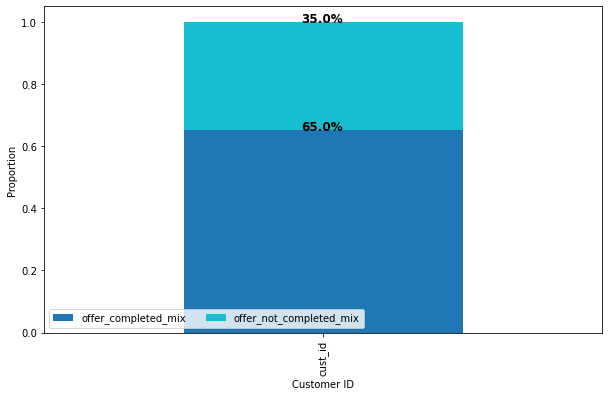

In [46]:
# Out of viewed offer, how many of them are completed?
table = pd.pivot_table(df, columns='event', values='cust_id', aggfunc='count')
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Customer ID")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
plt.show()

# 65% of customer who view their offer completed them

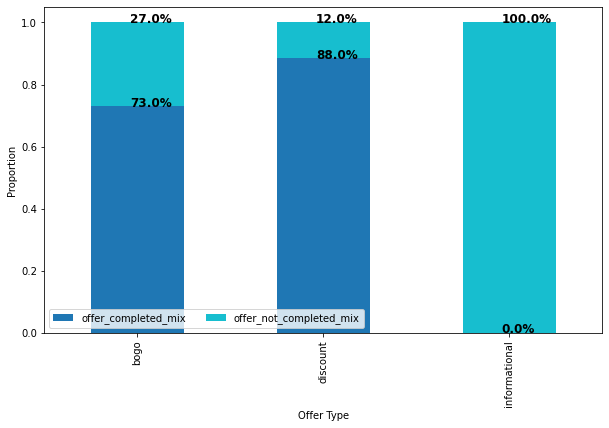

In [47]:
# Which offer type is the most popular
table = pd.pivot_table(df, index='offer_type', columns='event', values='cust_id', aggfunc=lambda x: len(x.unique()))
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table.fillna(0, inplace=True)
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)

# Plot
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
plt.show()

# Discount offer is more popular compared to BOGO
# No offer completed for informational offers they are merely advertisements

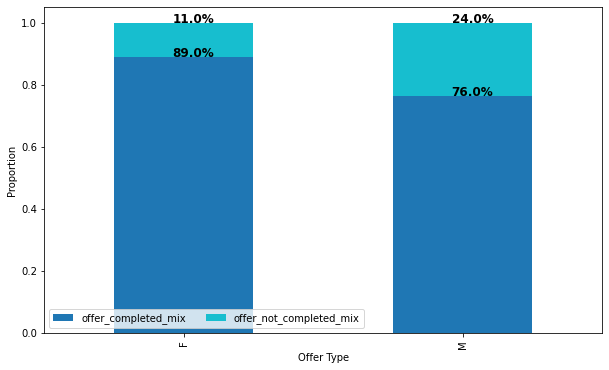

In [48]:
# Which gender is more likely to complete an offer
table = pd.pivot_table(df, index='gender', columns='event', values='cust_id', aggfunc=lambda x: len(x.unique()))
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table.fillna(0, inplace=True)
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)

# Plot
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.show()

# Female has higher percentage of customer completed their offers, followed closely by Others and Male.

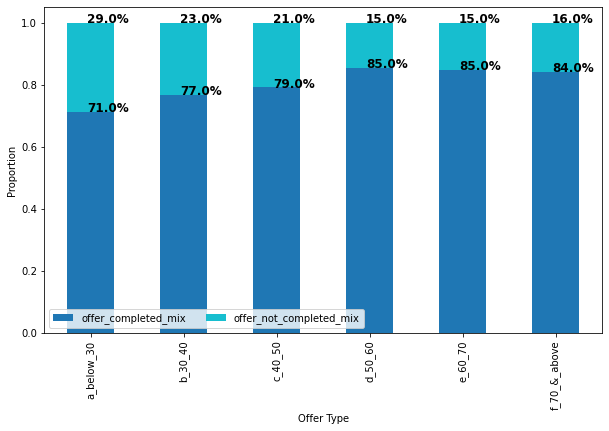

In [49]:
# Which age group is more likely to complete an offer
table = pd.pivot_table(df, index='age_grp', columns='event', values='cust_id', aggfunc=lambda x: len(x.unique()))
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table.fillna(0, inplace=True)
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)

# Plot
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")


plt.show()
# We can see an increasing trend in terms of percentage of customers completed their offers as the age increases.
# Older customers age 50 & above have higher likelihood to complete the offers

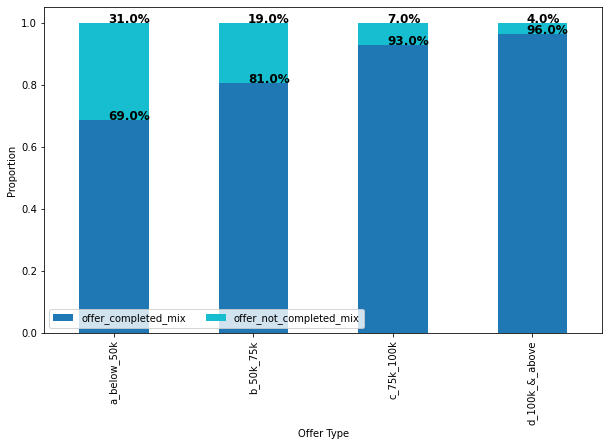

In [50]:
# Which income group is more likely to complete an offer
table = pd.pivot_table(df, index='income_grp', columns='event', values='cust_id', aggfunc=lambda x: len(x.unique()))
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table.fillna(0, inplace=True)
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)

# Plot
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")


plt.show()

# We can see an increasing trend in terms of percentage of customers completed their offers as the income increases.
# Higher income customers with 75k annual income & above have higher likelihood to complete the offers

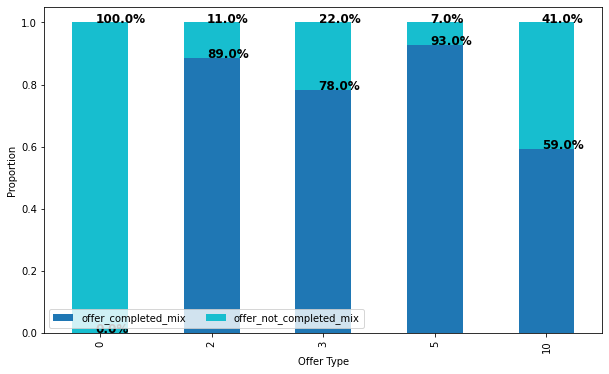

In [51]:
# Which offer reward has more likelihood to be completed
table = pd.pivot_table(df, index='offer_reward', columns='event', values='cust_id', aggfunc=lambda x: len(x.unique()))
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table.fillna(0, inplace=True)
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)

# Plot
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")


plt.show()

# There is no trend observed in the chart below
# It seems like the amount of reward doesn't influence customer's behaviour to complete the offers.

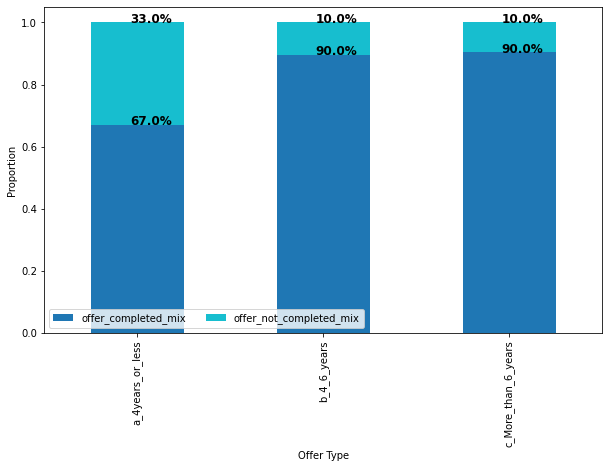

In [52]:
# Which membership duration is more likely to complete an offer
table = pd.pivot_table(df, index='membership_duration', columns='event', values='cust_id', aggfunc=lambda x: len(x.unique()))
table['offer_completed_mix'] = table['offer completed']/table['offer viewed']
table.fillna(0, inplace=True)
table['offer_not_completed_mix'] = 1-table['offer_completed_mix']
table.drop(columns=['offer completed', 'offer viewed'], axis=1, inplace=True)

# Plot
table.plot(kind='bar', 
           stacked=True, 
           colormap='tab10', 
           figsize=(10, 6))

plt.legend(loc="lower left", ncol=2)
plt.xlabel("Offer Type")
plt.ylabel("Proportion")
for n, x in enumerate([*table.index.values]):
    for (proportion, y_loc) in zip(table.loc[x],
                                   table.loc[x].cumsum()):
                
        plt.text(x=n-0.04,
                 y=y_loc,
                 s=f'{np.round(proportion * 100, 0)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")


plt.show()

# Customers with more than 4 years long of membership have higher likelihood of completing the offer

In [53]:
# Duration to complete an offer by gender
table = pd.pivot_table(df[df['event'] == 'offer completed'], index='gender', values='time', aggfunc=np.mean)
table['time'] = table['time']/24
table

# Males take slightly longer time to complete the offer compared to female.
# Looking at the small differences in time, it's fair to say offer has similar influences on female & male 

,time
gender,
F,16.54
M,16.78


# Data Condensation

In [54]:
# Create df to have unique cust id with uniqe offer id and event
# by removing duplicated based on cust_id, offer_id
df.drop_duplicates(subset=['cust_id', 'offer_id'], inplace=True)
len(df)

46242

# Correlation Analysis

AxesSubplot(0.141,0.125;0.604x0.755)


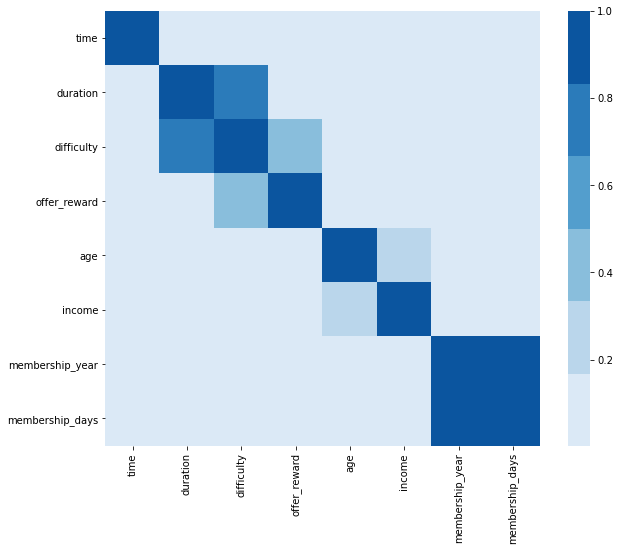

In [55]:
# Extract numerical variables and apply correlation tests
num_vars = ['time', 'duration', 'difficulty', 'offer_reward', 'age', 'income', 'membership_year', 'membership_days']
df_corr = df[num_vars]
 
# Plot heatmap
df_corr = df_corr.corr(method='spearman').abs()
ax = plt.figure(figsize=(10,8)).gca()
colormap = sns.color_palette("Blues")
print(sns.heatmap(df_corr, ax=ax, square=True, cmap=colormap))

# Strong correlation
# 1. difficulty x duration - 
# 2. difficult x offer reward


<AxesSubplot:>

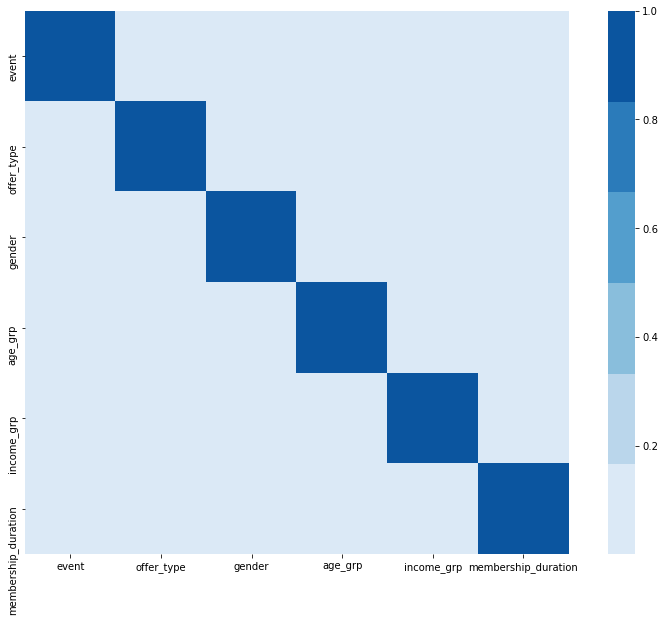

In [66]:
# Extract categorical
cat_vars = [ 'event', 'offer_type', 'gender', 'age_grp', 'income_grp', 'membership_duration']

df_assoc = df[cat_vars]

# Correlation between categorical variables
df_assoc = df_assoc.apply(lambda x: pd.factorize(x)[0]).corr(method='pearson').abs()

# Plot heatmap
ax1 = plt.figure(figsize=(14,10)).gca()
colormap = sns.color_palette("Blues")
sns.heatmap(df_assoc, square=True, cmap=colormap)

# Modelling

For modelling, I will include categorical and numerical predictor in the model as follows:

Numerical predictor
* age
* income
* membership_days

Categorical predictor
* gender
* offer_type

For categorical predictor, I will use **one-hot encoding** by creating dummy variable for categorical encoding. I need to convert categorical columns to numerical columns so that a machine learning algorithm understands it.
I choose one-hot encoding as the categorical predictor are **not ordinal** and **the number of categorical predictors is less** so one-hot encoding can be effectively applied. The first columns of each of categorical predictors are dropped from the data **to avoid multicollinearity issue**.

In [57]:
df1 = df[['event', 'gender', 'age', 'income', 'membership_days', 'offer_type']]

#categorical data
categorical_cols = ['gender', 'offer_type'] 

# Create dummy variabe
model_df = pd.get_dummies(df1, columns = categorical_cols, drop_first=True)
model_df['event'] = model_df.apply(lambda x: 1 if x['event'] in 'offer completed' else 0, axis=1)
model_df

,event,age,income,membership_days,gender_M,offer_type_discount,offer_type_informational
73850,1,33.00,72000.00,1788.00,1,1,0
39506,0,33.00,72000.00,1788.00,1,0,1
22001,0,33.00,72000.00,1788.00,1,0,1
46140,1,33.00,72000.00,1788.00,1,0,0
67238,1,33.00,72000.00,1788.00,1,1,0
...,...,...,...,...,...,...,...
8367,1,34.00,34000.00,1876.00,1,0,0
22917,1,45.00,62000.00,1935.00,0,1,0
40886,1,45.00,62000.00,1935.00,0,1,0
59226,1,45.00,62000.00,1935.00,0,0,0


In [59]:
# Split the data into predictor and response
X = model_df[['age', 'income', 'membership_days', 'gender_M', 'offer_type_discount', 'offer_type_informational']]
Y = model_df['event']
X.head()

,age,income,membership_days,gender_M,offer_type_discount,offer_type_informational
73850,33.00,72000.00,1788.00,1,1,0
39506,33.00,72000.00,1788.00,1,0,1
22001,33.00,72000.00,1788.00,1,0,1
46140,33.00,72000.00,1788.00,1,0,0
67238,33.00,72000.00,1788.00,1,1,0


In [60]:
Y.head()

73850    1
39506    0
22001    0
46140    1
67238    1
Name: event, dtype: int64

In [61]:
# Creating training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=69)

### Models

I will build multiple models to make comparison based on the metrics mentioned above and record their duration

In [62]:
# Logistic Regression
lr = LogisticRegression()
start_lr = time.time()
lr.fit(X_train, y_train)
duration_lr = round((time.time() - start_lr)/60, 3)

# Naive Bayes
gnb = GaussianNB() 
start_gnb = time.time()
gnb.fit(X_train, y_train) 
duration_gnb = round((time.time() - start_gnb)/60, 3)

# Stochastic Gradient Descent
sgd = SGDClassifier()
start_sgd = time.time()
sgd.fit(X_train, y_train)
duration_sgd = round((time.time() - start_sgd)/60, 3)

# Support Vector Machine
svm = SVC()
start_svm = time.time()
svm.fit(X_train, y_train)
duration_svm = round((time.time() - start_svm)/60, 3)

# Random Forest
rfm = RandomForestClassifier()
start_rfm = time.time()
rfm.fit(X_train, y_train)
duration_rfm = round((time.time() - start_rfm)/60, 3)

# K-Nearest Neighbors
knn = KNeighborsClassifier()
start_knn = time.time()
knn.fit(X_train, y_train)
duration_knn = round((time.time() - start_knn)/60, 3)

### Model Evaluation

In [63]:
# Initialize empty dataframe to store the results
df_result = pd.DataFrame(columns=['duration', 'accuracy', 'precision', 'recall', 'f1_score'])

# List of model to evaluate, its model names and duration
model_list = [lr, gnb, svm, sgd, rfm, knn]
model_name_list = ['lr', 'naive_bayes',  'svm', 'sgd', 'rfm', 'knn']
model_duration_map = {'lr': duration_lr,
                      'naive_bayes': duration_gnb,
                      'svm': duration_svm,
                      'sgd': duration_sgd,
                      'rfm': duration_rfm,
                      'knn': duration_knn}

# Predict on test data - Random Forest
i = 0
for p_ in model_list:
    
    # Make predictions
    y_pred_ = p_.predict(X_test)

    # Calculate metrics
    accuracy_ = np.round(100 * (y_pred_ == y_test).mean().mean(), 2)
    precision_ = precision_recall_fscore_support(y_test, y_pred_, average='weighted')[0]
    recall_ = precision_recall_fscore_support(y_test, y_pred_, average='weighted')[1]
    f1_score_ = precision_recall_fscore_support(y_test, y_pred_, average='weighted')[2]
    
    # Append records
    df_result.loc[model_name_list[i], :] = [model_duration_map.get(model_name_list[i]), 
                                            accuracy_,
                                            precision_,
                                            recall_,
                                            f1_score_]
    
    # Update counter
    i += 1
    
# View results table
df_result

C:\Users\sitinurdinie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sitinurdinie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sitinurdinie\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,duration,accuracy,precision,recall,f1_score
lr,0.01,77.03,0.77,0.77,0.77
naive_bayes,0.00,75.50,0.77,0.75,0.74
svm,1.80,60.73,0.58,0.61,0.54
sgd,0.02,39.89,0.16,0.40,0.23
rfm,0.09,80.07,0.80,0.80,0.80
knn,0.00,65.22,0.64,0.65,0.65


Based on result tabulated above:
* Support Vector Machine took the longest time to run but produced middle range of accuracy level.
* Stochastic Gradient Descent has the lowest accuracy compared to other models. Maybe it requires a number of hyper-parameters to improve the result.
* K-Nearest Neighbor model produce middle range of accuracy level. This is maybe because I only used  default k values fixed in scikit-learn which is 5. To improve this model, I could use elbow method to determine the best k value
* Logistic Regression, Naive Bayes and Random Forest models achieved higher level of accuracy compared to other models.
* Considering the metrics and duration tabulated above, Random Forest is the best model to be selected as the final model as it has the highest accuracy and reasonable amount of time to run.

In [64]:
# Random Forest (Grid Search)
parameters = {
        'n_estimators': [100, 200], # default=100
        'min_samples_split': [2, 4] # default=2
    }

# Grid Search using 4-fold cross-validation on Random Forest by doubling the hyperparameter levels
rfm_cv = GridSearchCV(rfm, param_grid=parameters, cv=4)

# Model fitting
start_cv = time.time()
rfm_cv.fit(X_train, y_train)
duration_cv = round((time.time() - start_cv)/60, 3)

# Output best selection of parameters
print(rfm_cv.best_params_)

{'min_samples_split': 4, 'n_estimators': 200}


In [65]:
# Evaluate the final model
y_pred_cv = rfm_cv.predict(X_test)

# Get model duration
print(f'Time taken: {duration_cv} minutes')

# Calculate metrics
accuracy_cv = np.round(100 * (y_pred_cv == y_test).mean().mean(), 2)
print(f'Model accuracy: {accuracy_cv}%')

# Get precision, recall and fl-score
print(classification_report(y_test.values, y_pred_cv))

Time taken: 1.743 minutes
Model accuracy: 80.42%
              precision    recall  f1-score   support

           0       0.78      0.71      0.74      4612
           1       0.82      0.87      0.84      6949

    accuracy                           0.80     11561
   macro avg       0.80      0.79      0.79     11561
weighted avg       0.80      0.80      0.80     11561



Based on Grid Search, the model can be further improved by having min_samples_split of 4 and n_estimator of 200.  Doubling of min_samples_split and increasing of n_estimator improves the model by 0.42% which is not a significant improvement. Therefore, I choose  default Random Forest model as the final model due to its good performance based on the metrics tabulated above.

# Conclusion

In this project, I have analysed customer profile, offer and transaction data provided by Starbucks to build and select a model that can predict which customer would complete or only view Starbucks offer. To do this, I perform data exporation on datasets provided to understand promotion offer, customer profile and transaction behaviour of the customers. I use data visualization to look for any trends and to assist my understanding. Before I start modelling, I performed Correlation Analysis to avoid using predictors that are correlate with each other and narrow down the predictors to be used in the model. I build multiple models using different classification algorithm to compare and select model with the best performance based on metrics and duration to run. The final model is Random Forest model with accuracy of 80%

# Reflection

Through this project, I learned about the importance of defining and understanding a problem statement. When there's a lot of data available, there are a lot of analysis that can be done and it is easy to stray away from the real objective of the project. Good understanding about a project can help one to identify better on what data that he/she truly needs.

The most challenging but interesting part are to learn and identify the type of algorithm I should use to solve the problem. In this project, I learn more about different types of classification algorithms. Although I didnt fully explored the hyper parameter and tuning for the model, this is definitely a good start for me.

# Improvement

The final model result achieve 80% of accuracy which is pretty good to me. I think the data collection can be improved to fix the issues related to missing values in the data. The missing values in the data is 2175 which is 13% of the customer dataset. For me, this is quite a lot. Having more data to learn from always good to improve the model's accuracy and credibility. Another thing that can be improved is to try more complex algorithm like  Ensemble method. It is generally more complex than the traditional ones and traditional methods can give a good base level from which it can be improved by creating the ensembles.